In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

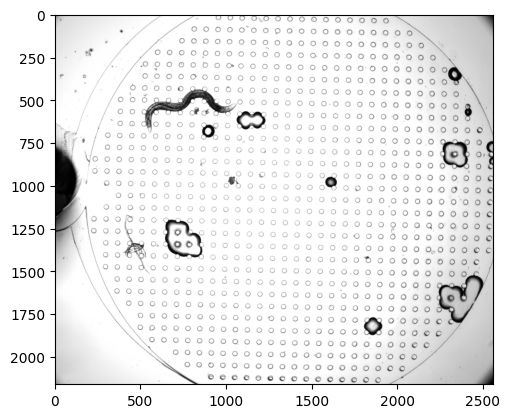

In [2]:
frame = cv2.imread('frame10.png')
plt.imshow(frame, cmap='gray')
plt.show()

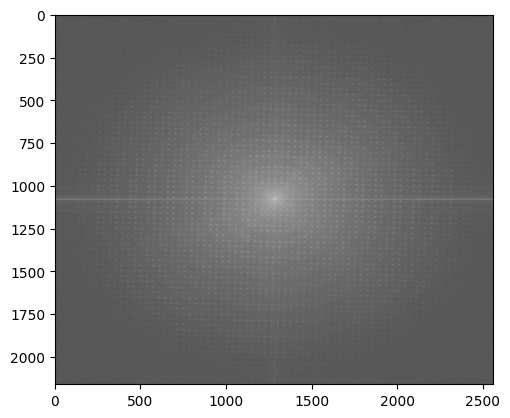

In [5]:
# Convert the frame to grayscale
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Frequency Magnitude Analysis for the frame
f = np.fft.fft2(gray_frame)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift) + 1e-8)  # Add a small constant to avoid log(0)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()

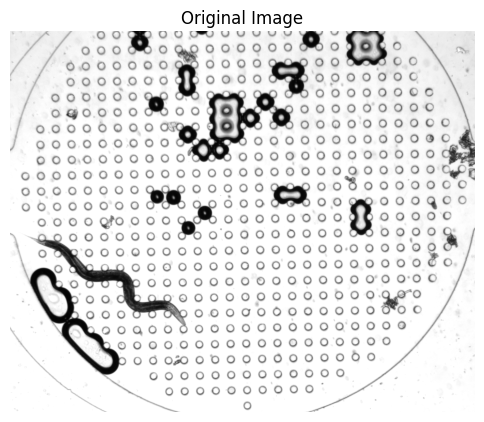

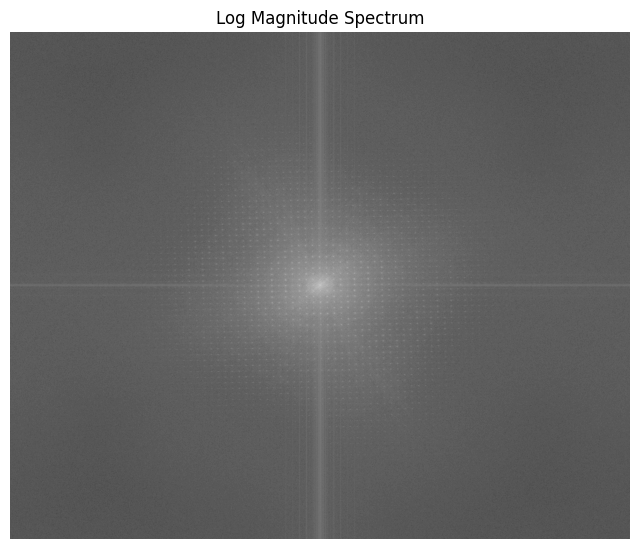

Otsu's threshold value: 22.0
Detected peak positions:
(927, 1430)
(928, 1370)
(928, 1400)
(929, 1281)
(929, 1311)
(930, 1251)
(951, 1460)
(975, 1491)
(977, 1341)
(977, 1371)
(977, 1401)
(978, 1282)
(978, 1312)
(979, 1252)
(999, 1521)
(1000, 1461)
(1001, 1372)
(1001, 1402)
(1001, 1431)
(1002, 1312)
(1002, 1342)
(1003, 1252)
(1003, 1282)
(1004, 1223)
(1024, 1522)
(1024, 1551)
(1025, 1432)
(1025, 1462)
(1026, 1372)
(1026, 1402)
(1027, 1283)
(1027, 1313)
(1027, 1342)
(1028, 1223)
(1028, 1253)
(1029, 1163)
(1048, 1552)
(1049, 1462)
(1049, 1492)
(1050, 1403)
(1050, 1432)
(1051, 1313)
(1051, 1343)
(1051, 1373)
(1052, 1254)
(1052, 1283)
(1053, 1194)
(1053, 1224)
(1054, 1134)
(1063, 1343)
(1069, 1335)
(1069, 1349)
(1069, 1353)
(1069, 1378)
(1070, 1318)
(1070, 1327)
(1070, 1387)
(1072, 1335)
(1072, 1355)
(1072, 1381)
(1073, 1338)
(1073, 1350)
(1073, 1493)
(1073, 1552)
(1074, 1358)
(1074, 1433)
(1075, 1314)
(1075, 1353)
(1075, 1373)
(1075, 1379)
(1075, 1403)
(1076, 1284)
(1076, 1320)
(1076, 1328)

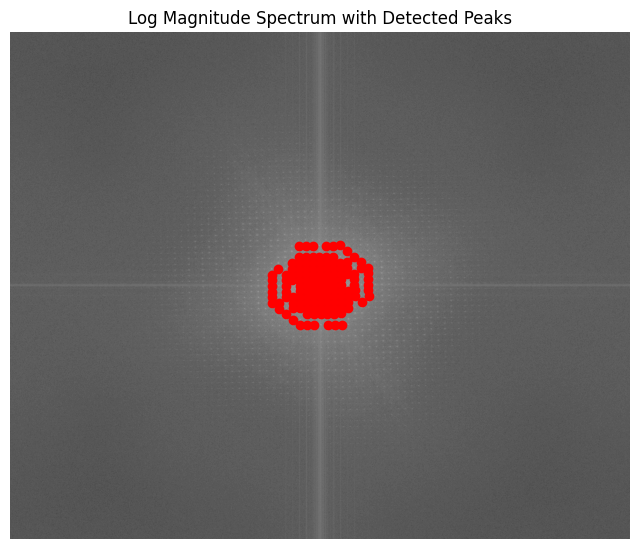

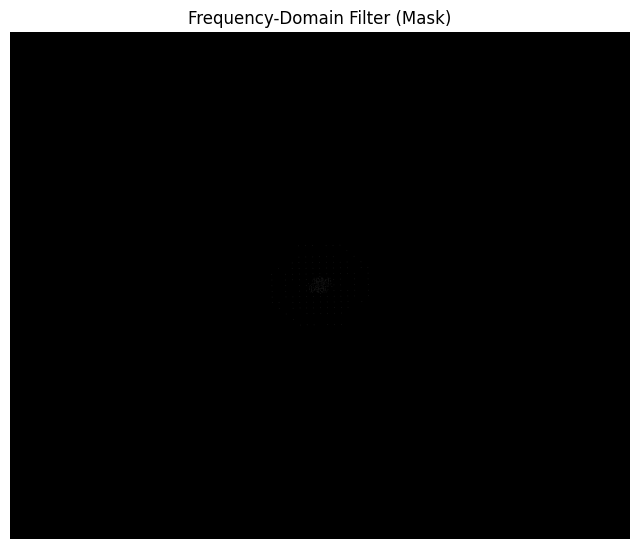

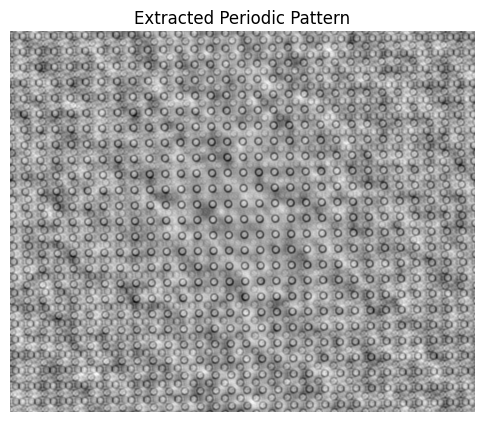

In [8]:
!pip install scipy
from scipy.ndimage import maximum_filter, label, find_objects
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, label, find_objects

filename = r'first_frame.jpg'
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

f_transform = np.fft.fft2(image)
f_shifted = np.fft.fftshift(f_transform)

magnitude_spectrum = np.abs(f_shifted)

log_magnitude_spectrum = np.log(magnitude_spectrum + 1)

plt.figure(figsize=(8, 8))
plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.title('Log Magnitude Spectrum')
plt.axis('off')
plt.show()

neighborhood_size = 5

data_max = maximum_filter(magnitude_spectrum, neighborhood_size)

local_max = (magnitude_spectrum == data_max)

dc_y, dc_x = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
magnitude_spectrum_no_dc = magnitude_spectrum.copy()
magnitude_spectrum_no_dc[dc_y - 1:dc_y + 2, dc_x - 1:dc_x + 2] = 0

norm_magnitude = cv2.normalize(magnitude_spectrum_no_dc, None, 0, 255, cv2.NORM_MINMAX)
norm_magnitude_uint8 = norm_magnitude.astype(np.uint8)

otsu_threshold_value, otsu_mask = cv2.threshold(
    norm_magnitude_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
print(f"Otsu's threshold value: {otsu_threshold_value}")

otsu_mask_bool = otsu_mask.astype(bool)

final_mask = local_max & otsu_mask_bool

labeled, num_objects = label(final_mask)

slices = find_objects(labeled)
peak_positions = []
for dy, dx in slices:
    x_center = (dx.start + dx.stop - 1) // 2
    y_center = (dy.start + dy.stop - 1) // 2
    peak_positions.append((y_center, x_center))

dc_y, dc_x = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
if (dc_y, dc_x) not in peak_positions:
    peak_positions.append((dc_y, dc_x))

print("Detected peak positions:")
for pos in peak_positions:
    print(pos)

plt.figure(figsize=(8, 8))
plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.title('Log Magnitude Spectrum with Detected Peaks')
plt.axis('off')

for pos in peak_positions:
    plt.plot(pos[1], pos[0], 'ro')

plt.show()

mask = np.zeros_like(magnitude_spectrum, dtype=np.uint8)
for pos in peak_positions:
    y, x = pos
    mask[y, x] = 1

plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('Frequency-Domain Filter (Mask)')
plt.axis('off')
plt.show()

f_filtered = f_shifted * mask

f_ishift = np.fft.ifftshift(f_filtered)
img_filtered = np.fft.ifft2(f_ishift)
img_filtered = np.abs(img_filtered)

img_filtered_norm = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX)
img_filtered_norm = img_filtered_norm.astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(img_filtered_norm, cmap='gray')
plt.title('Extracted Periodic Pattern')
plt.axis('off')
plt.show()

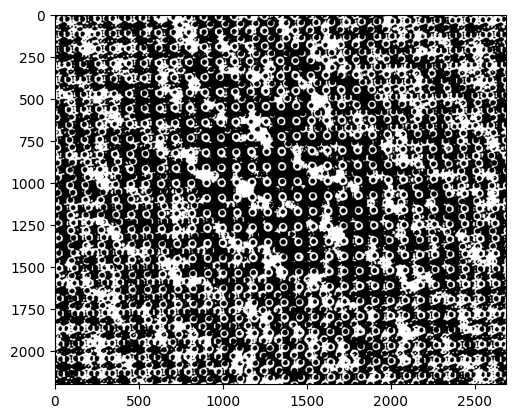

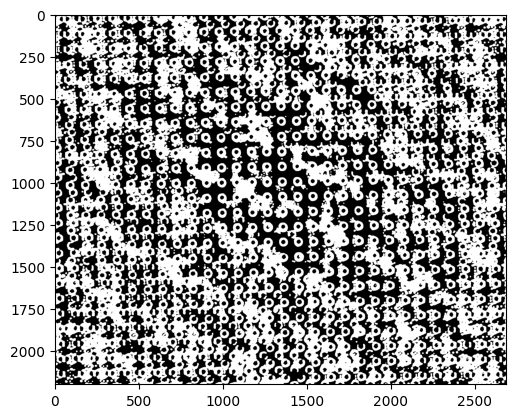

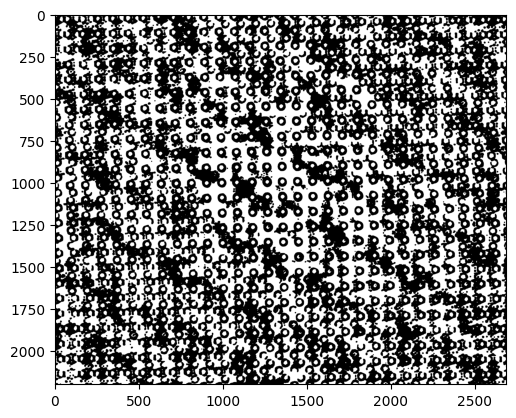

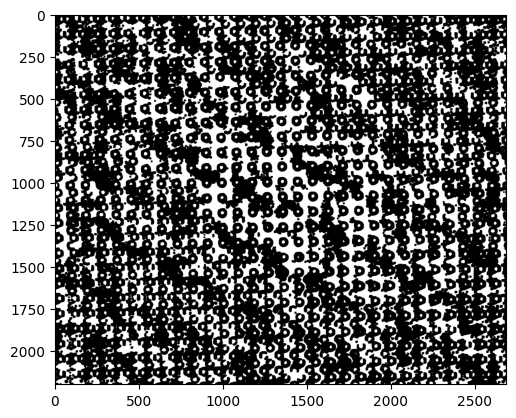

In [12]:
# threshed = cv2.adaptiveThreshold(img_filtered_norm, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 30)
# plt.imshow(threshed, cmap='gray')
# plt.show()
threshed = cv2.threshold(img_filtered_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
threshedInverse = cv2.bitwise_not(threshed)
plt.imshow(threshedInverse, cmap='gray')
plt.show()
threshedInverseDilated = cv2.dilate(threshedInverse, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6)), iterations=1)
plt.imshow(threshedInverseDilated, cmap='gray')
plt.show()
invert = cv2.bitwise_not(threshedInverseDilated)
plt.imshow(invert, cmap='gray')
plt.show()
invertEroded = cv2.erode(invert, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6)), iterations=1)
plt.imshow(invertEroded, cmap='gray')
plt.show()
Eroded = cv2.bitwise_not(invertEroded)

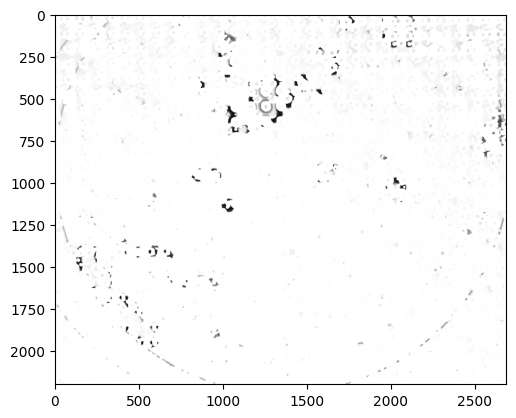

In [13]:
frame_copy = frame.copy()

# Use threshedInverse as a mask to set corresponding pixels to 255
frame_copy[Eroded!= 0] = 255

# Display the modified frame
plt.imshow(frame_copy, cmap='gray')
plt.show()

In [6]:

video_path = 'Worm2.avi'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read the first frame
ret, frame = cap.read()

if ret:
    # Save the first frame as an image
    cv2.imwrite('first_frame.jpg', frame)
    print("First frame saved as first_frame.jpg")
else:
    print("Error: Could not read the first frame.")

# Release the video capture
cap.release()

First frame saved as first_frame.jpg
